In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack, Distances
using Plots

In [3]:
# Parameters
grid_resolution        = 100
quadrature_order       = 2
selected_ev            = 2;      # which Eigenvector to choose
ϵ                      = 0.5     # perturbation
a                      = 0.98;   # parameter value corresponding to ϵ=0

In [4]:
T(x ,p) = [rem2pi(x[1] + x[2] + (a+p)*sin(x[1]), RoundDown),
           rem2pi(       x[2] + (a+p)*sin(x[1]), RoundDown)]

T (generic function with 1 method)

In [5]:
T_inv(x, p) = [rem2pi(x[1] - x[2], RoundDown),
               rem2pi(x[2] - (a+p)*sin(x[1] - x[2]), RoundDown)]

T_inv (generic function with 1 method)

In [6]:
LL, UR = (0.0, 0.0), (2π, 2π)
ctx, _ = regularTriangularGrid((grid_resolution, grid_resolution), LL, UR, quadrature_order = quadrature_order)
pred(x,y) = peuclidean(x, y, [2π, 2π]) < 1e-9
bdata = BoundaryData(ctx, pred);

In [7]:
M = assembleMassMatrix(ctx, bdata=bdata);

In [8]:
@time A,_ = nonAdaptiveTOCollocation(ctx, y -> T_inv(y,0),project_in=true, bdata_domain=bdata);

  1.174816 seconds (4.03 M allocations: 233.956 MiB, 4.83% gc time)


In [9]:
@time D⁰ = assembleStiffnessMatrix(ctx, bdata=bdata)
@time D¹ = A'*D⁰*A
K = 0.5(D⁰+D¹);

  0.344554 seconds (1.09 M allocations: 67.349 MiB, 4.22% gc time)
  0.111929 seconds (239.11 k allocations: 21.441 MiB)


In [10]:
# solve the linear system
@time λ₀, u₀ = eigs(K, M, which=:SM)
@assert all(imag.(u₀) .== 0)
@assert all(imag.(λ₀) .== 0)
u₀ = real.(u₀[:,selected_ev])
λ₀ = real.(λ₀[selected_ev])
u₀ = u₀ ./ sqrt(u₀'*M*u₀)        # L2 normalization
if u₀[Int(floor(0.25*grid_resolution*grid_resolution+0.5*grid_resolution))]<0
    u₀ = -u₀
end
λ₀

  3.497826 seconds (9.10 M allocations: 573.080 MiB, 4.02% gc time)


-1.1036728313741566

In [11]:
# assemble the linear response matrix L
@time L = nonadaptiveTOCollocationLinearResponseMatrix(ctx, T, A, 0, bdata=bdata);

  2.674302 seconds (9.59 M allocations: 601.945 MiB, 5.01% gc time)


In [12]:
# solve the system for the derivative u_dot
lhs = [K-λ₀*M   -M*u₀
        u₀'*M      0]
rhs = [-L*u₀    ;  0]

@time b = lhs \ rhs
u_dot = b[1:end-1]
λ_dot = b[end]

  0.883997 seconds (2.50 M allocations: 181.602 MiB, 4.85% gc time)


-0.22349431299139444

In [13]:
# calculate the exact uϵ
@time Aϵ,_ = nonAdaptiveTOCollocation(ctx, y -> T_inv(y,ϵ),project_in=true,bdata_domain=bdata);
@time D¹ϵ = Aϵ'*D⁰*Aϵ
Kϵ = 0.5(D⁰+D¹ϵ);
λϵ, uϵ = eigs(Kϵ, M, which=:SM)
@assert all(imag.(uϵ) .== 0)
@assert all(imag.(λϵ) .== 0)
uϵ = real.(uϵ[:,selected_ev])
λϵ = real.(λϵ[selected_ev])
uϵ = uϵ ./ sqrt(uϵ'*M*uϵ)
if uϵ[Int(floor(0.25*grid_resolution*grid_resolution+0.5*grid_resolution))]<0
    uϵ = -uϵ
end
λϵ

  0.164732 seconds (644.97 k allocations: 65.818 MiB)
  0.020679 seconds (30 allocations: 9.526 MiB, 65.67% gc time)


-1.249133192239434

In [14]:
λ₀ + ϵ*λ_dot

-1.2154199878698537

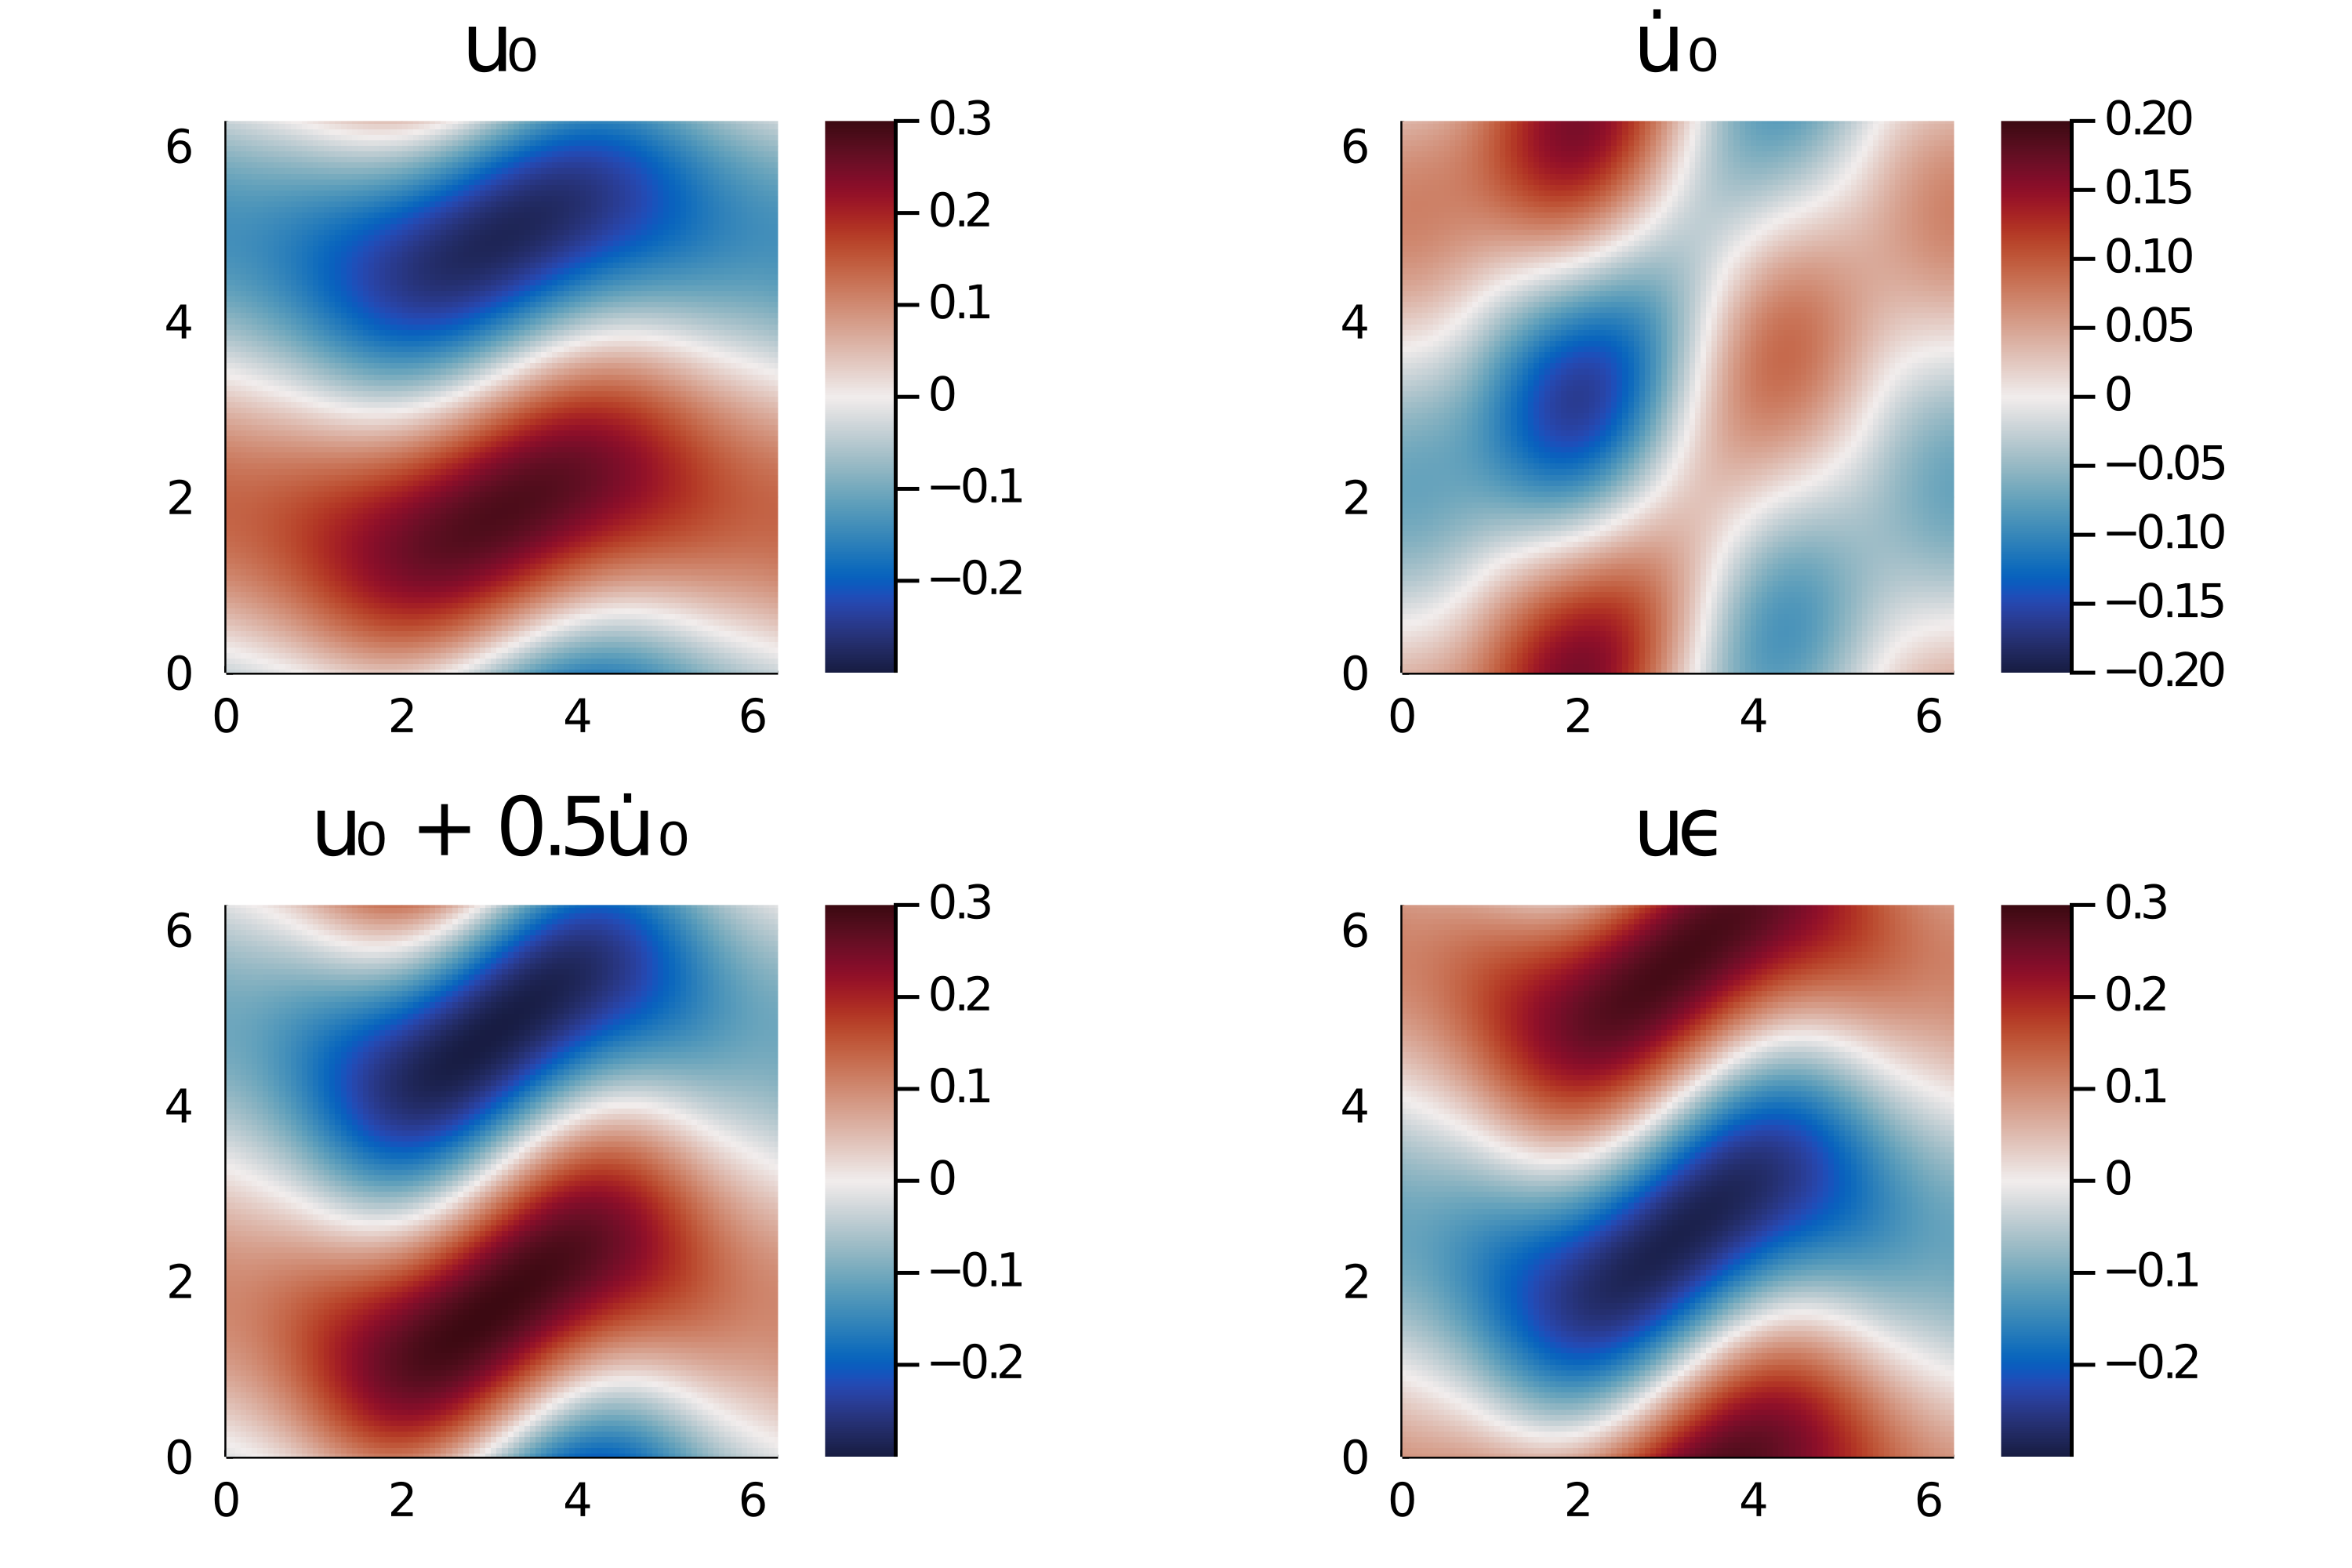

In [15]:
color =    :balance
xticks =   0:2:6
yticks =   0:2:6
colorbar = :left
cmin =     -0.3
cmax =     0.3
cmin_lr =  -0.2
cmax_lr =  0.2
#unfortunately there is no option for colorbar ticks


original      = plot_u(ctx, u₀,  grid_resolution, grid_resolution, title="u₀", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
derivative    = plot_u(ctx, u_dot,       grid_resolution, grid_resolution, title="u̇ ₀", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin_lr,cmax_lr), xticks=xticks, yticks=yticks)
extrapolated  = plot_u(ctx, u₀ + ϵ*u_dot, grid_resolution, grid_resolution, title="u₀ + $(ϵ)u̇ ₀", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
exact         = plot_u(ctx, uϵ,          grid_resolution, grid_resolution, title="uϵ", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
Plots.plot(original,derivative,extrapolated,exact, fmt=:png, dpi=500)

In [16]:
using Contour
using StaticArrays

In [17]:
#Contour.jl needs StaticArrays
T_static(x) = SVector{2,Float64}(T(x,0))

T_static (generic function with 1 method)

In [18]:
function dynamic_cheeger_value_levelset(levelset)
    curves = lines(levelset)
    if length(curves) != 1 
        @warn "Currently only connected levelsets are allowed! Levelset: ", level(levelset)
    end
    curve = curves[1]
    return dynamic_cheeger_value(ctx,curve,T_static,tolerance=1e-10)
end
function dynamic_cheeger_value_levelset_nonnegative(levelset)
    if level(levelset) < 0
        return Inf
    end
    curves = lines(levelset)
    if length(curves) != 1 
        @warn "Currently only connected levelsets are allowed! Levelset: $(level(levelset))"
    end
    curve = curves[1]
    return dynamic_cheeger_value(ctx,curve,T_static,tolerance=1e-10)
end

best_levelset, best_value = get_minimal_levelset(
    ctx,u₀,dynamic_cheeger_value_levelset_nonnegative,n_candidates=1000,bdata=bdata)
print("Dynamic Cheeger value:\t",best_value,"\n")
print("Levelset:\t\t",level(best_levelset),"\n")

┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.00028504277777030573
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.000854707243472197
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.0014243717091740327
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.0019940361748758684
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.0025637006405777596
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.0031333651062795953
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.003703029571981431
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.004272694037683322
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.004842358503385158
└ @ Main In[18]:15
┌ Warning: Cu

┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.052124509156638854
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.052694173622340745
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.05326383808804258
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.05383350255374442
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.05440316701944625
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.054972831485148144
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.05554249595084998
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.056112160416551815
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.056681824882253706
└ @ Main In[18]:15
┌ Warning: Currently on

┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10453364000120924
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10510330446691113
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10567296893261297
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.1062426333983148
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10681229786401669
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10738196232971853
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10795162679542036
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.1085212912611222
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10909095572682409
└ @ Main In[18]:15
┌ Warning: Currently only conn

Dynamic Cheeger value:	1.9860739842976622
Levelset:		0.2161878752787723


cheeger value		length			length transported	volume
2.0747561640688628	13.143216825637744	24.81558091237537	9.147773216774315
1.9860739842976622	8.267346311615377	7.162461711723451	3.8844998084991507


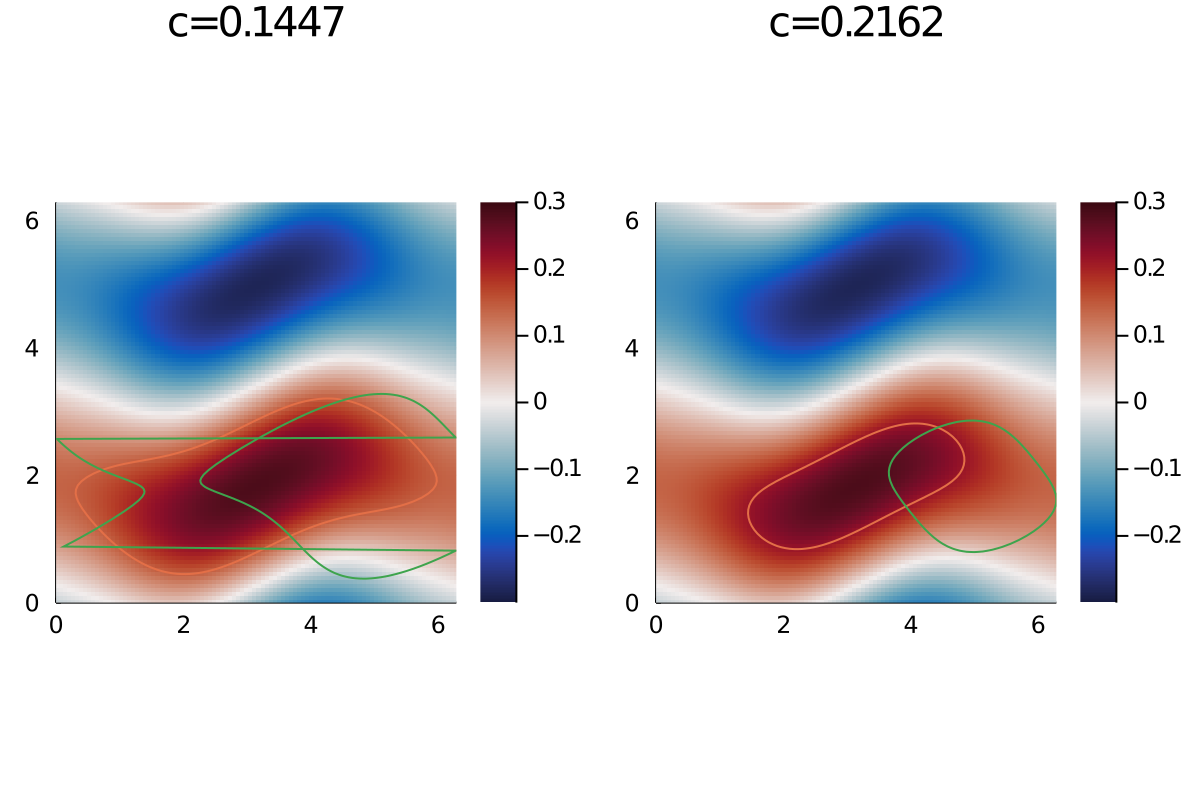

In [19]:
# value from paper
c_paper = 0.1447
plot_paper = plot_u(ctx, u₀,  grid_resolution, grid_resolution, title="c=$(round(c_paper,digits=4))",bdata=bdata,
        colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks,legend=false)

curve = lines(get_levelset(ctx, u₀, c_paper, bdata=bdata))[1]
curve_moved = Main.CoherentStructures.apply2curve(T_static,curve)

cheeger_value = dynamic_cheeger_value(ctx, curve, T_static)
print("cheeger value\t\tlength\t\t\tlength transported\tvolume\n")
print("$(cheeger_value)\t$(Main.CoherentStructures.getLength(curve))\t",
    "$(Main.CoherentStructures.getLength(curve_moved))\t$(Main.CoherentStructures.getEuclideanArea(ctx,curve))\n")

Plots.plot!(coordinates(curve))
Plots.plot!(coordinates(curve_moved))

# our value
c_ours = level(best_levelset)
plot_ours = plot_u(ctx, u₀,  grid_resolution, grid_resolution, title="c=$(round(c_ours,digits=4))",bdata=bdata,
        colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks,legend=false)

curve = lines(get_levelset(ctx, u₀, c_ours, bdata=bdata))[1]
curve = Main.CoherentStructures.closeCurve(ctx,curve)
curve_moved = Main.CoherentStructures.apply2curve(T_static,curve)

cheeger_value = dynamic_cheeger_value(ctx, curve, T_static)
print("$(cheeger_value)\t$(Main.CoherentStructures.getLength(curve))\t",
    "$(Main.CoherentStructures.getLength(curve_moved))\t$(Main.CoherentStructures.getEuclideanArea(ctx,curve))\n")

Plots.plot!(coordinates(curve))
Plots.plot!(coordinates(curve_moved))


Plots.plot(plot_paper, plot_ours, fmt=:png,dpi=200)

In [20]:
function plot_vectorfield(xs,ys,dx,dy;scale=1,step=1)
    xs, ys = xs[1:step:end], ys[1:step:end]
    x_coords = repeat(xs, outer=length(ys))
    y_coords = repeat(ys, inner=length(xs))
    dx, dy = scale.*dx[1:step:end,1:step:end], scale.*dy[1:step:end,1:step:end]
    quiver(x_coords,y_coords,quiver=(vec(dx),vec(dy)))
end

plot_vectorfield (generic function with 1 method)

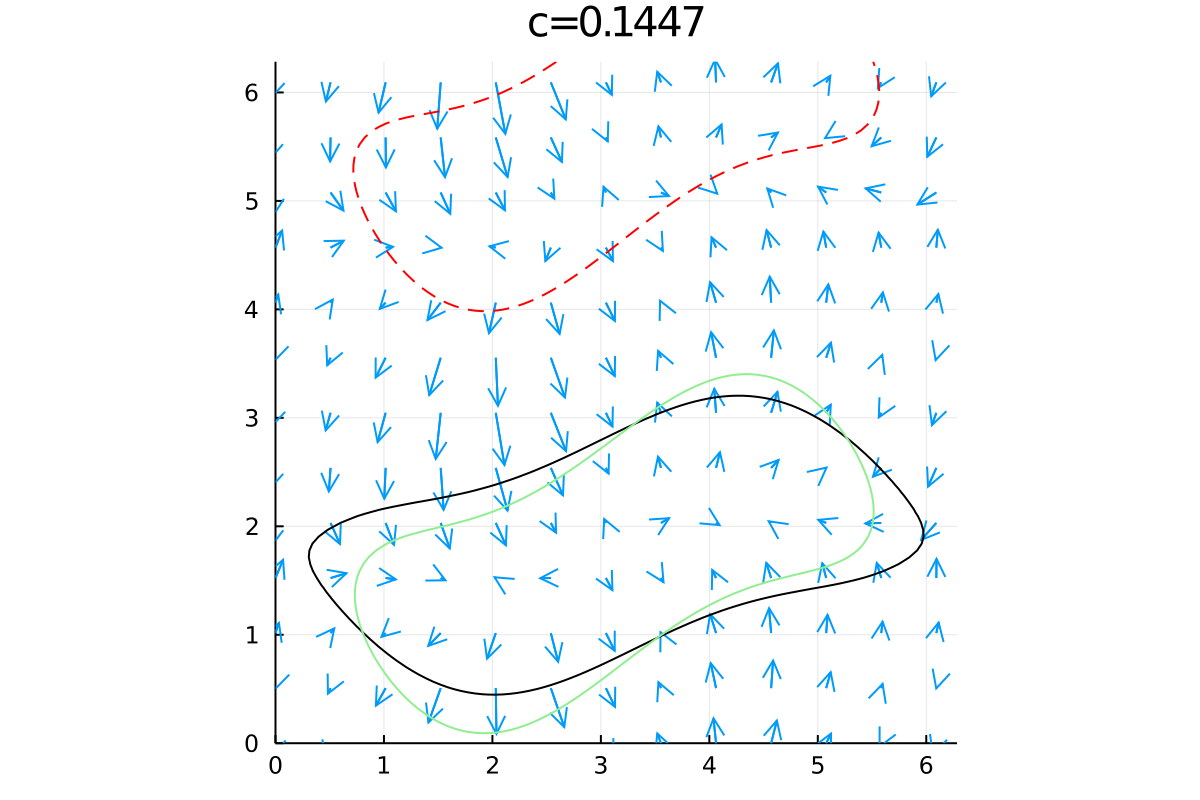

In [21]:
plot_vectorfield(get_levelset_evolution(ctx,u₀,u_dot, bdata=bdata)...,scale=3,step=8)
curve         = lines(get_levelset(ctx, u₀, c_paper, bdata=bdata))[1]
curve_epsilon = lines(get_levelset(ctx, uϵ, c_paper, bdata=bdata))[1]
curves_predicted = lines(get_levelset(ctx, u₀ + ϵ*u_dot, c_paper, bdata=bdata))


plot!(coordinates(curve),color=:black)
plot!(coordinates(curve_epsilon),color=:red,linestyle=:dash)
for c in curves_predicted
    plot!(coordinates(c),color=:lightgreen)
end

Plots.plot!(fmt=:png,dpi=200,legend=false,aspectratio=1,xlims=(0,2π),ylims=(0,2π),title="c=$(round(c_paper,digits=4))")